In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


In [2]:
### Getting the data -- in this case, rented_last_month will be the target variable
###Justification of variables:

###1. Title - self explanatory
###2. Historical rental volume - Through counting the distinct rental_ids to date we can tell how many times (across all copies) 
### a particular film title has been rented thus far
###3. Rental price - Assuming cheaper titles are more likely to be rented ,to some degree
###4. Average rental duration in days - the shorter the rental duration, the sooner it becomes available for rent. I manually
### calculated it just because I wanted to see if my python formula works
###5. Rented last month - As a recent indication of possible fluctuations in popularity (new release? seasonal christmas films?.
### Also our target variable
###6. Rating, length, and category - Film characteristics that may appeal differently to different viewer segments



In [ ]:
###NB: I thought of including the variable 'special_features' but after some digging via SQL, every film has special features
###and that meant I would need to create a dummy variable for every type of special feature, making the model
### more complex than I can handle given the time constraints. It also needs to be cleaned because the values are messed up
###:( So this is just to let you know that I've thought about it, and I'll do it when I have the time to revisit this lab

In [ ]:
###NB2: I've included an extra part on how to improve the model towards the very end!

In [ ]:
### Reading the SQL dataframe

In [64]:
query = '''
SELECT f.title, COUNT(DISTINCT i.inventory_id) AS number_of_copies, COUNT(DISTINCT rental_id)
 AS historical_rental_volume, f.rental_rate AS rental_price, ROUND(avg( to_days(return_date)
          - to_days(rental_date) ))
        as average_rental_duration_in_days, f.length, f.rating, c.name AS category,
CASE WHEN MAX(rental_date) >= '2006-02-01' AND MAX(rental_date) < '2006-03-01' THEN TRUE ELSE FALSE END AS rented_last_month
FROM rental
JOIN inventory AS i USING (inventory_id)
JOIN film  AS f USING (film_id)
JOIN film_category AS fc USING (film_id)
JOIN category AS c USING (category_id)
GROUP BY f.title, f.rental_rate, f.length, f.rating, c.name;
;


'''

data = pd.read_sql_query(query, engine)
data.head()

,title,number_of_copies,historical_rental_volume,rental_price,average_rental_duration_in_days,length,rating,category,rented_last_month
0,ACADEMY DINOSAUR,7,24,0.99,5.0,86,PG,Documentary,0
1,ACE GOLDFINGER,3,7,4.99,6.0,48,G,Horror,1
2,ADAPTATION HOLES,4,12,2.99,3.0,50,NC-17,Documentary,0
3,AFFAIR PREJUDICE,7,23,2.99,5.0,117,G,Horror,1
4,AFRICAN EGG,3,12,2.99,7.0,130,G,Family,1


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            958 non-null    object 
 1   number_of_copies                 958 non-null    int64  
 2   historical_rental_volume         958 non-null    int64  
 3   rental_price                     958 non-null    float64
 4   average_rental_duration_in_days  958 non-null    float64
 5   length                           958 non-null    int64  
 6   rating                           958 non-null    object 
 7   category                         958 non-null    object 
 8   rented_last_month                958 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 67.5+ KB


In [66]:
data.shape #958 rows, 9 columns

(958, 9)

In [67]:
data.isna().sum().sum()  ### no nulls in the entire dataframe

0

In [68]:
df1 = data[data.isna().any(axis=1)] ###cross checking for nulls
print(df1)

Empty DataFrame
Columns: [title, number_of_copies, historical_rental_volume, rental_price, average_rental_duration_in_days, length, rating, category, rented_last_month]
Index: []


In [69]:
print(data['title'].unique())

['ACADEMY DINOSAUR' 'ACE GOLDFINGER' 'ADAPTATION HOLES' 'AFFAIR PREJUDICE'
 'AFRICAN EGG' 'AGENT TRUMAN' 'AIRPLANE SIERRA' 'AIRPORT POLLOCK'
 'ALABAMA DEVIL' 'ALADDIN CALENDAR' 'ALAMO VIDEOTAPE' 'ALASKA PHANTOM'
 'ALI FOREVER' 'ALIEN CENTER' 'ALLEY EVOLUTION' 'ALONE TRIP'
 'ALTER VICTORY' 'AMADEUS HOLY' 'AMELIE HELLFIGHTERS' 'AMERICAN CIRCUS'
 'AMISTAD MIDSUMMER' 'ANACONDA CONFESSIONS' 'ANALYZE HOOSIERS'
 'ANGELS LIFE' 'ANNIE IDENTITY' 'ANONYMOUS HUMAN' 'ANTHEM LUKE'
 'ANTITRUST TOMATOES' 'ANYTHING SAVANNAH' 'APACHE DIVINE'
 'APOCALYPSE FLAMINGOS' 'ARABIA DOGMA' 'ARACHNOPHOBIA ROLLERCOASTER'
 'ARIZONA BANG' 'ARMAGEDDON LOST' 'ARMY FLINTSTONES' 'ARTIST COLDBLOODED'
 'ATLANTIS CAUSE' 'ATTACKS HATE' 'ATTRACTION NEWTON' 'AUTUMN CROW'
 'BABY HALL' 'BACKLASH UNDEFEATED' 'BADMAN DAWN' 'BAKED CLEOPATRA'
 'BALLOON HOMEWARD' 'BALLROOM MOCKINGBIRD' 'BANG KWAI' 'BANGER PINOCCHIO'
 'BARBARELLA STREETCAR' 'BAREFOOT MANCHURIAN' 'BASIC EASY'
 'BEACH HEARTBREAKERS' 'BEAR GRACELAND' 'BEAST HUNCHBACK' 'B

In [70]:
### No duplicates in film tiles, the only column where values need to be unique
print(data['title'].value_counts())

ACADEMY DINOSAUR      1
PERSONAL LADYBUGS     1
PARK CITIZEN          1
PARTY KNOCK           1
PAST SUICIDES         1
                     ..
FULL FLATLINERS       1
FURY MURDER           1
GABLES METROPOLIS     1
GALAXY SWEETHEARTS    1
ZORRO ARK             1
Name: title, Length: 958, dtype: int64


In [71]:
##Data preprocessing

In [72]:
data.rental_price.nunique()

3

In [73]:
data.rental_price.unique()

array([0.99, 4.99, 2.99])

In [74]:
### Limited and predefined price categories, so rental_price will be transformed into a categorical variable

In [75]:
data['rental_price']= data['rental_price'].astype('object')
data.describe()

,number_of_copies,historical_rental_volume,average_rental_duration_in_days,length,rented_last_month
count,958.000000,958.000000,958.000000,958.000000,958.000000
mean,4.780793,16.748434,5.026096,115.490605,0.175365
std,1.814825,6.677241,0.774696,40.471844,0.380478
min,2.000000,4.000000,2.000000,46.000000,0.000000
25%,3.000000,11.000000,5.000000,80.250000,0.000000
50%,5.000000,16.000000,5.000000,114.000000,0.000000
75%,6.000000,22.000000,5.000000,150.000000,0.000000
max,8.000000,34.000000,7.000000,185.000000,1.000000


In [55]:
### rental_price is no longer an integer as it no longer shows up when describe() is prompted 

In [56]:
data['rental_price'].value_counts()

0.99    326
4.99    320
2.99    312
Name: rental_price, dtype: int64

In [101]:
data['rating'].unique()

array(['PG', 'G', 'NC-17', 'PG-13', 'R'], dtype=object)

In [102]:
data['category'].unique()

array(['Documentary', 'Horror', 'Family', 'Foreign', 'Comedy', 'Sports',
       'Music', 'Animation', 'Action', 'New', 'Sci-Fi', 'Classics',
       'Games', 'Children', 'Travel', 'Drama'], dtype=object)

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            958 non-null    object 
 1   number_of_copies                 958 non-null    int64  
 2   historical_rental_volume         958 non-null    int64  
 3   rental_price                     958 non-null    object 
 4   average_rental_duration_in_days  958 non-null    float64
 5   length                           958 non-null    int64  
 6   rating                           958 non-null    object 
 7   category                         958 non-null    object 
 8   rented_last_month                958 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 67.5+ KB


In [57]:
##Standardizing the titles

In [78]:
data['title']= data['title'].apply(lambda x: x.lower())
print(data.title)

0       academy dinosaur
1         ace goldfinger
2       adaptation holes
3       affair prejudice
4            african egg
             ...        
953       young language
954           youth kick
955         zhivago core
956    zoolander fiction
957            zorro ark
Name: title, Length: 958, dtype: object


In [79]:
data['title']= data['title'].apply(lambda x : x.title())
print(data.title)

0       Academy Dinosaur
1         Ace Goldfinger
2       Adaptation Holes
3       Affair Prejudice
4            African Egg
             ...        
953       Young Language
954           Youth Kick
955         Zhivago Core
956    Zoolander Fiction
957            Zorro Ark
Name: title, Length: 958, dtype: object


In [80]:
###EDA

In [81]:
datacorr= round(data.corr(),2)
datacorr

,number_of_copies,historical_rental_volume,average_rental_duration_in_days,length,rented_last_month
number_of_copies,1.00,0.93,0.06,-0.04,0.18
historical_rental_volume,0.93,1.00,0.05,-0.03,0.15
average_rental_duration_in_days,0.06,0.05,1.00,-0.01,0.07
length,-0.04,-0.03,-0.01,1.00,-0.01
rented_last_month,0.18,0.15,0.07,-0.01,1.00


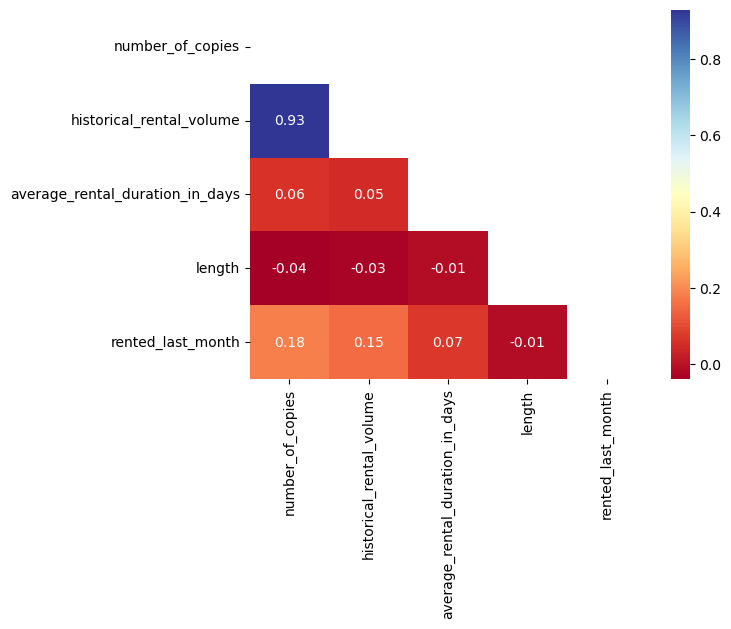

In [82]:
mask = np.zeros_like(datacorr, dtype=bool)
mask[np.triu_indices_from(mask)]= True
sns.heatmap(datacorr, annot= True, mask=mask, cmap='RdYlBu')
plt.show()

In [83]:
### There is evidence of multicollinearity between historical_rental_colume and number of copies. Therefore I will be dropping
## historical_rental_volume, as the aim of this lab is to see what titles to stock up

In [84]:
data= data.drop('historical_rental_volume', axis= 'columns')


In [39]:
data.head()

,title,number_of_copies,rental_price,average_rental_duration_in_days,rented_last_month
0,Academy Dinosaur,7,0.99,5.0,0
1,Ace Goldfinger,3,4.99,6.0,1
2,Adaptation Holes,4,2.99,3.0,0
3,Affair Prejudice,7,2.99,5.0,1
4,African Egg,3,2.99,7.0,1


C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='number_of_copies', ylabel='Density'>

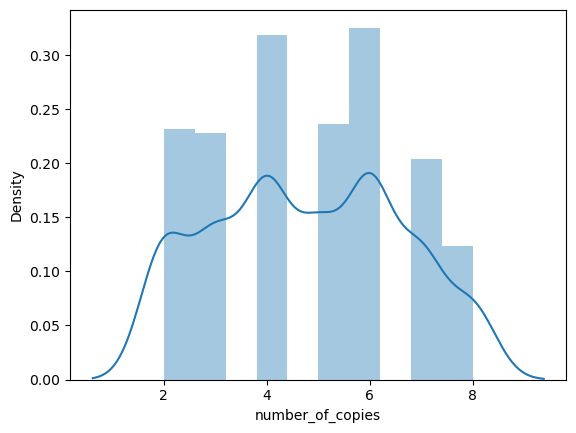

In [94]:
sns.distplot(data['number_of_copies']) # Appears normally distributed, therefore there is no need for transformation

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='average_rental_duration_in_days', ylabel='Density'>

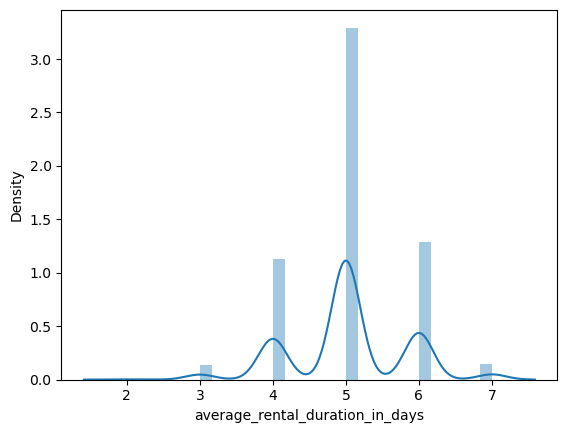

In [96]:
sns.distplot(data['average_rental_duration_in_days']) # Appears normally distributed, therefore no need for transformation

C:\Users\HP\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length', ylabel='Density'>

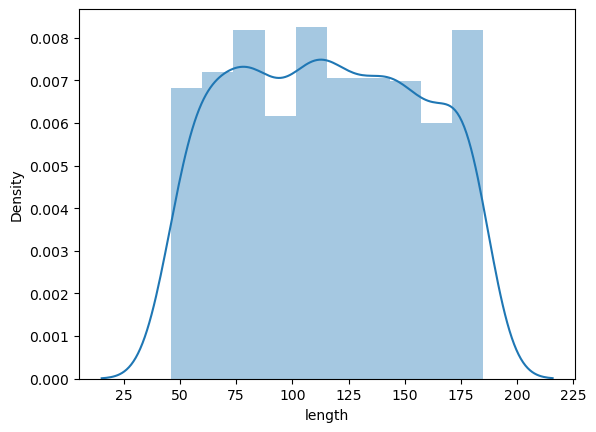

In [97]:
sns.distplot(data['length']) # Data is normally distributed, although values are bunched towards the middle --owing to the
#nature of the variable itself (I can't really think of 10 minute feature films....)

In [ ]:
### Data Normalization

In [103]:
X= data.select_dtypes(include =np.number)

transformer= StandardScaler().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)
x.columns= X.columns
x.head()

,number_of_copies,average_rental_duration_in_days,length,rented_last_month
0,1.223460,-0.033703,-0.729050,-0.461149
1,-0.981760,1.257800,-1.668465,2.168497
2,-0.430455,-2.616709,-1.619022,-0.461149
3,1.223460,-0.033703,0.037314,2.168497
4,-0.981760,2.549302,0.358693,2.168497


In [105]:
cat= data.select_dtypes(include= np.object)
cat= cat.drop(['title'], axis =1)
categorical = pd.get_dummies(cat, columns=['rental_price', 'rating', 'category'])

C:\Users\HP\AppData\Local\Temp\ipykernel_10796\301787283.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat= data.select_dtypes(include= np.object)
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [ ]:
### Train-Test Split and Training Model

In [106]:
y = data['rented_last_month'] #target
X= np.concatenate((x, categorical), axis=1)

In [107]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=100)

In [108]:
classification= LogisticRegression(random_state=0, multi_class='multinomial').fit(X_train, y_train)

In [109]:
predictions= classification.predict(X_test)

In [ ]:
### Model Performance

In [ ]:
###Based on these values alone, we can tell that there are not enough data points from one month alone 
### to produce an accurate prediction model!

In [110]:
pd.Series(predictions).value_counts()  

0    237
1     51
dtype: int64

In [111]:
y_test.value_counts()

0    237
1     51
Name: rented_last_month, dtype: int64

In [113]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[237,   0],
       [  0,  51]], dtype=int64)

<AxesSubplot:>

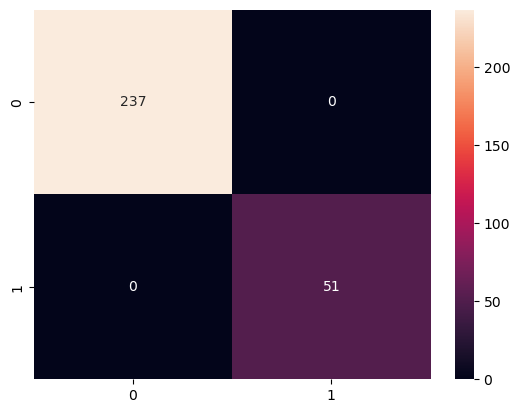

In [114]:
cm= confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='g')

In [ ]:
### Accuracy -- which doesn't matter in this case because we know that the model is flawed

In [115]:
classification.score(X_test, y_test)

1.0

In [116]:
from sklearn.metrics import accuracy_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test,predictions)))


Accuracy: 1.00



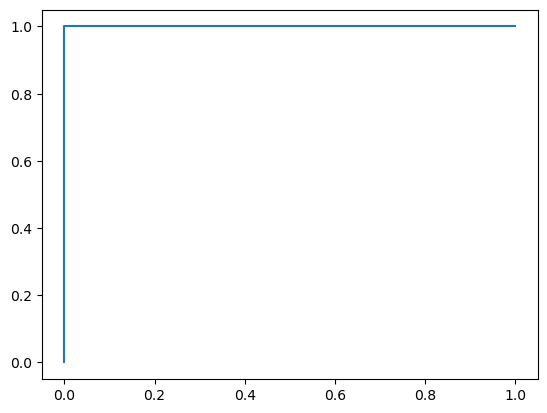

In [117]:
y_pred_proba = classification.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)

In [ ]:
###Course of Action

In [ ]:
### 1. We need to incorporate more dummy variables based on the whether they were rented or not for every single month the 
### title was avaliable for rent at the Sakila video rental stores.
### Right now, the only historical variable is 'rented_last_month'(also our target variable), which only encompasses a month's 
### worth of rental transactions. Many films are seasonal in popularity and this can only be observed a longer period of time.
### It's hard to extrapolate seasonality just from a month of data points!

In [ ]:
###2. We could also incorporate other variables such as actor information, film_id, language, payment etc to make the model
### more robust, but in my opinion these variables are less related to the target variable.